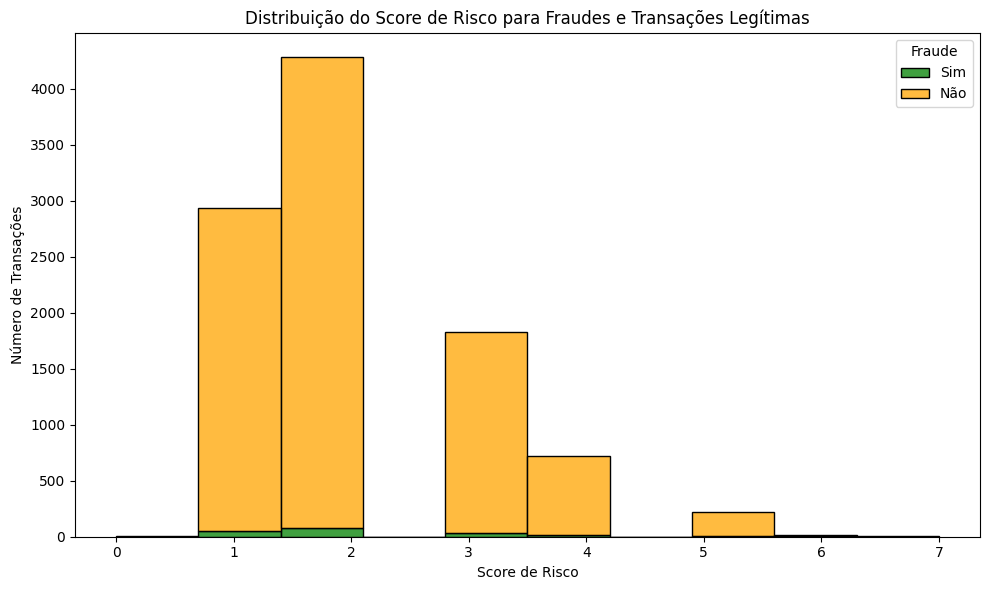

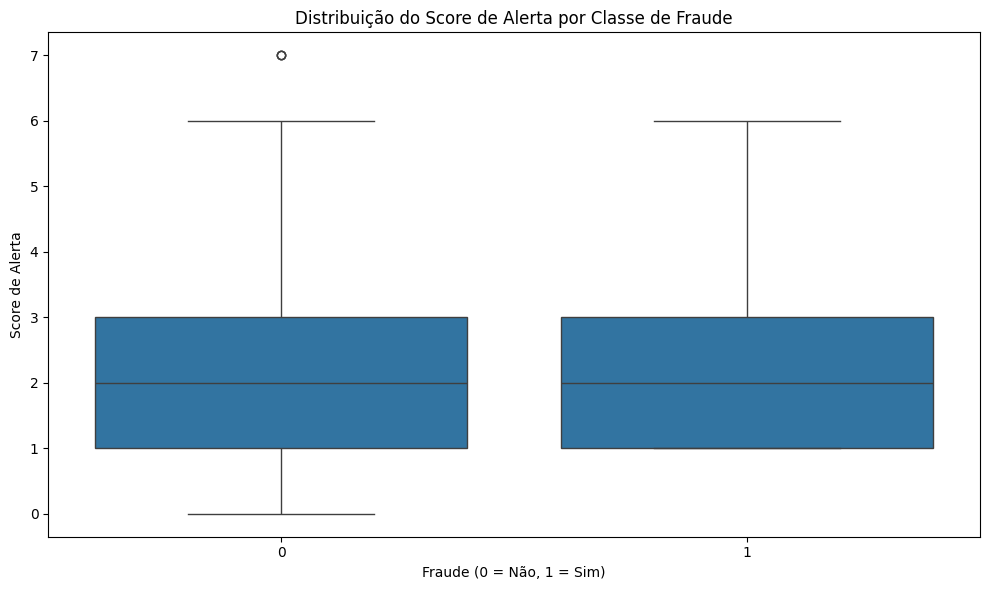

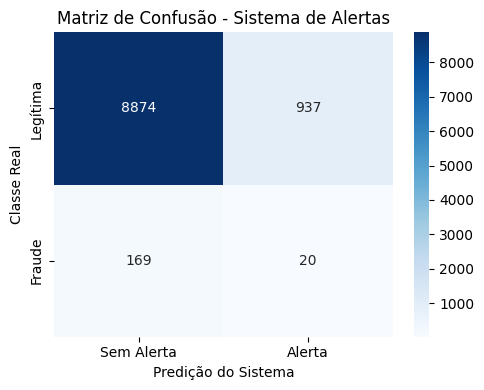

Métricas de Desempenho do Sistema de Alertas:
Acurácia:  0.8894
Precisão:  0.0209
Recall:    0.1058
F1-Score:  0.0349


In [4]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ---------------------------
# 1. GERAR DATASET SIMULADO
# ---------------------------
n = 10000
ids_transacoes = [f"TX{i:06d}" for i in range(n)]
ids_usuarios = [f"U{random.randint(1, 1000):04d}" for _ in range(n)]
valores = np.round(np.random.normal(loc=200, scale=50, size=n), 2)
valores[np.random.choice(n, size=200, replace=False)] *= 10  # outliers

data_inicio = datetime(2024, 1, 1)
datas = [data_inicio + timedelta(minutes=random.randint(0, 60*24*90)) for _ in range(n)]
horas = [dt.hour for dt in datas]
canais = np.random.choice(['app', 'web', 'ATM'], size=n, p=[0.5, 0.3, 0.2])
latitudes = np.random.uniform(-30.0, -3.0, n)
longitudes = np.random.uniform(-70.0, -34.0, n)
dispositivos = np.random.choice(['iPhone', 'Android', 'Windows', 'Linux'], size=n)
fraudes = np.random.choice([0, 1], size=n, p=[0.98, 0.02])

df = pd.DataFrame({
    'id_transacao': ids_transacoes,
    'id_usuario': ids_usuarios,
    'valor': valores,
    'data_hora': datas,
    'hora': horas,
    'canal': canais,
    'latitude': latitudes,
    'longitude': longitudes,
    'dispositivo': dispositivos,
    'fraude': fraudes
})

# ---------------------------
# 2. FEATURE ENGINEERING E SCORE
# ---------------------------
def adicionar_features(df):
    df = df.copy()
    df['turno'] = df['hora'].apply(lambda x: 'madrugada' if x < 6 else
                                               'manha' if x < 12 else
                                               'tarde' if x < 18 else 'noite')
    df['valor_alto'] = df['valor'] > 1000
    df['canal_suspeito'] = df['canal'].isin(['web', 'POS'])

    localizacao = df[['latitude', 'longitude']].apply(lambda row: f"{round(row.iloc[0], 1)}_{round(row.iloc[1], 1)}", axis=1)
    df['localizacao_bloque'] = localizacao
    local_por_usuario = df.groupby('id_usuario')['localizacao_bloque'].transform(lambda x: x.nunique())
    df['localizacao_rara'] = local_por_usuario > 2

    freq_usuario = df['id_usuario'].value_counts()
    df['frequencia_usuario'] = df['id_usuario'].map(freq_usuario)
    df['alta_frequencia'] = df['frequencia_usuario'] > freq_usuario.quantile(0.90)

    return df

def gerar_score_alerta(df):
    df = df.copy()
    df['score_alerta'] = 0
    df['score_alerta'] += df['valor_alto'] * 2
    df['score_alerta'] += df['canal_suspeito'] * 1
    df['score_alerta'] += df['localizacao_rara'] * 1
    df['score_alerta'] += df['alta_frequencia'] * 2
    df['score_alerta'] += df['turno'].isin(['madrugada', 'noite']) * 1
    df['alerta_binario'] = df['score_alerta'] >= 4
    return df

# ---------------------------
# 3. PROCESSAMENTO
# ---------------------------
df_alertas = gerar_score_alerta(adicionar_features(df))

# Paleta personalizada
palette_custom = {'0': 'green', '1': 'orange'}

# ---------------------------
# 4. HISTOGRAMA: Score vs Fraude
# ---------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=df_alertas, x='score_alerta', hue='fraude', multiple='stack', bins=10, palette=['orange', 'green'])
plt.title('Distribuição do Score de Risco para Fraudes e Transações Legítimas')
plt.xlabel('Score de Risco')
plt.ylabel('Número de Transações')
plt.legend(title='Fraude', labels=['Sim', 'Não'])
plt.tight_layout()
plt.show()

# ---------------------------
# 5. BOXPLOT: Score por classe de fraude
# ---------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_alertas, x='fraude', y='score_alerta')
plt.title('Distribuição do Score de Alerta por Classe de Fraude')
plt.xlabel('Fraude (0 = Não, 1 = Sim)')
plt.ylabel('Score de Alerta')
plt.tight_layout()
plt.show()

# ---------------------------
# 6. MATRIZ DE CONFUSÃO
# ---------------------------
matriz = confusion_matrix(df_alertas['fraude'], df_alertas['alerta_binario'])

plt.figure(figsize=(5, 4))
sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Sem Alerta", "Alerta"],
            yticklabels=["Legítima", "Fraude"])
plt.xlabel("Predição do Sistema")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão - Sistema de Alertas")
plt.tight_layout()
plt.show()

# ---------------------------
# 7. MÉTRICAS DE DESEMPENHO
# ---------------------------
y_true = df_alertas['fraude']
y_pred = df_alertas['alerta_binario']

acuracia = accuracy_score(y_true, y_pred)
precisao = precision_score(y_true, y_pred)
revocacao = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Métricas de Desempenho do Sistema de Alertas:")
print(f"Acurácia:  {acuracia:.4f}")
print(f"Precisão:  {precisao:.4f}")
print(f"Recall:    {revocacao:.4f}")
print(f"F1-Score:  {f1:.4f}")
